In [1]:
import zipfile
from matplotlib import pyplot as plt
from collections import Counter
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [2]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
!wget -O Sherlock.txt https://www.gutenberg.org/ebooks/48320.txt.utf-8
!unzip wiki-news-300d-1M.vec.zip

--2023-10-31 02:28:39--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.226.210.111, 13.226.210.78, 13.226.210.25, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.226.210.111|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 681808098 (650M) [application/zip]
Saving to: ‘wiki-news-300d-1M.vec.zip’

wiki-news-300d-1M.v 100%[===================>] 650.22M  16.2MB/s    in 36s     

2023-10-31 02:29:15 (18.2 MB/s) - ‘wiki-news-300d-1M.vec.zip’ saved [681808098/681808098]

--2023-10-31 02:29:16--  https://www.gutenberg.org/ebooks/48320.txt.utf-8
Resolving www.gutenberg.org (www.gutenberg.org)... 152.19.134.47, 2610:28:3090:3000:0:bad:cafe:47
Connecting to www.gutenberg.org (www.gutenberg.org)|152.19.134.47|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: http://www.gutenberg.org/cache/epub/48320/pg48320.txt [following]
-

In [3]:
with open("Sherlock.txt", 'r', encoding='utf-8') as file:
    book = file.read()

In [4]:
import re
alphabets= "([A-Za-z])"
prefixes = "(Mr|St|Mrs|Ms|Dr|no|No)[.]"
suffixes = "(Inc|Ltd|Jr|Sr|Co)"
starters = "(Mr|Mrs|Ms|Dr|Prof|Capt|Cpt|Lt|He\s|She\s|It\s|They\s|Their\s|Our\s|We\s|But\s|However\s|That\s|This\s|Wherever)"
acronyms = "([A-Z][.][A-Z][.](?:[A-Z][.])?)"
websites = "[.](com|net|org|io|gov|edu|me)"
digits = "([0-9])"
multiple_dots = r'\.{2,}'

def split_into_sentences(text: str) -> list[str]:
    """
    Split the text into sentences.

    If the text contains substrings "<prd>" or "<stop>", they would lead
    to incorrect splitting because they are used as markers for splitting.

    :param text: text to be split into sentences
    :type text: str

    :return: list of sentences
    :rtype: list[str]
    """
    text = " " + text + "  "
    text = text.replace("\n"," ")
    text = re.sub(prefixes,"\\1<prd>",text)
    text = re.sub(websites,"<prd>\\1",text)
    text = re.sub(digits + "[.]" + digits,"\\1<prd>\\2",text)
    text = re.sub(multiple_dots, lambda match: "<prd>" * len(match.group(0)) + "<stop>", text)
    if "Ph.D" in text: text = text.replace("Ph.D.","Ph<prd>D<prd>")
    text = re.sub("\s" + alphabets + "[.] "," \\1<prd> ",text)
    text = re.sub(acronyms+" "+starters,"\\1<stop> \\2",text)
    text = re.sub(alphabets + "[.]" + alphabets + "[.]" + alphabets + "[.]","\\1<prd>\\2<prd>\\3<prd>",text)
    text = re.sub(alphabets + "[.]" + alphabets + "[.]","\\1<prd>\\2<prd>",text)
    text = re.sub(" "+suffixes+"[.] "+starters," \\1<stop> \\2",text)
    text = re.sub(" "+suffixes+"[.]"," \\1<prd>",text)
    text = re.sub(" " + alphabets + "[.]"," \\1<prd>",text)
    if "”" in text: text = text.replace(".”","”.")
    if "\"" in text: text = text.replace(".\"","\".")
    if "!" in text: text = text.replace("!\"","\"!")
    if "?" in text: text = text.replace("?\"","\"?")
    text = text.replace(".",".<stop>")
    text = text.replace("?","?<stop>")
    text = text.replace("!","!<stop>")
    text = text.replace("<prd>",".")
    sentences = text.split("<stop>")
    sentences = ['<SOS> ' + s.strip() + ' <EOS>' for s in sentences]
    if sentences and not sentences[-1]: sentences = sentences[:-1]
    return sentences

In [5]:
book = split_into_sentences(book)

In [6]:
book[1000:1002]

['<SOS> I had come to the conclusion that he had dropped asleep, and indeed was nodding myself, when he suddenly sprang out of his chair with the gesture of a man who has made up his mind, and put his pipe down upon the mantel-piece. <EOS>',
 '<SOS> “Sarasate plays at the St. James’s Hall this afternoon,” he remarked. <EOS>']

In [7]:
maxTokens = 5000
token = Tokenizer(num_words=maxTokens,
                  filters='!"“”#$%&()*+,.-/:;=?@[\\]^_`{|}~\t\n\ufeff\u2002', lower=True,
                  split=' ', char_level=False, oov_token=None)
token.fit_on_texts(book)

In [8]:
sequences = token.texts_to_sequences(book)

In [9]:
maxLen = len(max(sequences, key=len))

In [10]:
maxLen

153

In [11]:
def create_dataset(sequence):
    inputs = []
    outputs = []
    for i, sent in enumerate(sequence):
        for j in range(1, len(sent)-1):
          inputs.append(sent[:j])
          outputs.append([sent[j]])

    return inputs, outputs

In [12]:
X, y = create_dataset(sequences)
x_train = pad_sequences(X, maxlen=maxLen)
y_train = np.array(y)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.3)

In [13]:
token.sequences_to_texts([X[20]])

['<sos> the project gutenberg ebook of adventures of sherlock holmes this ebook is for the use of anyone anywhere in the']

In [14]:
reverse_dictionary = token.index_word
dictionary = dict([(value, key) for (key, value) in reverse_dictionary.items()])
num_words=len(dictionary)+1

In [15]:
import codecs
import IPython.display as ipd
from IPython.display import Audio, update_display
from ipywidgets import IntProgress

EMB = "wiki-news-300d-1M.vec"
N = 1000000

#load embeddings
print('loading word embeddings...')
embeddings_index = {}
f = codecs.open(f'./{EMB}', encoding='utf-8')
bar = IntProgress(min=0, max=N)
ipd.display(bar)

i = 0
for n, line in enumerate(f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
    if n//(N//100) > i:
          bar.value = n
          i += 1
f.close()
print('found %s word vectors' % len(embeddings_index))

loading word embeddings...


IntProgress(value=0, max=1000000)

found 999995 word vectors


In [16]:
embed_dim=300
embedding_matrix=np.zeros([num_words, embed_dim])
for word, idx in dictionary.items():
  if word in embeddings_index:
    embedding_matrix[idx,:]=embeddings_index[word]

In [50]:
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout, Dense, Input, Concatenate, Dot, RepeatVector, TimeDistributed, Multiply, Lambda, Flatten, Activation, Reshape, BatchNormalization
import tensorflow.keras.backend as K
from tensorflow.keras.activations import softmax
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import optimizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

nb_words = len(embedding_matrix) #Vocabulary size
embed_dim = len(embedding_matrix[0]) #Vectorization dim
value_dim = 100
maxLen = len(x_train[0])

In [51]:
input_layer = Input(shape=(maxLen,)) #Cantidad maxima de la frase de entrada, estos son los timesteps para este caso
embedding_layer = Embedding(nb_words, embed_dim, weights=[embedding_matrix], input_length=maxLen, trainable=True)(input_layer)
lstm = LSTM(value_dim, return_sequences=False, activation="tanh")(embedding_layer)
drop = Dropout(0.4)(lstm)
dense2 = Dense(nb_words, activation='softmax')(drop)
model = Model(inputs=input_layer, outputs=dense2)

In [52]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 153)]             0         
                                                                 
 embedding_3 (Embedding)     (None, 153, 300)          2652900   
                                                                 
 lstm_3 (LSTM)               (None, 100)               160400    
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense_7 (Dense)             (None, 8843)              893143    
                                                                 
Total params: 3706443 (14.14 MB)
Trainable params: 3706443 (14.14 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [53]:
callbackROP = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5)
callbackES = EarlyStopping(monitor='val_loss', patience=10)

In [54]:
model.compile(loss="sparse_categorical_crossentropy", optimizer='adam')

In [55]:
model.fit(x=x_train, y=y_train, validation_data=(x_test, y_test), batch_size=512, epochs=50, callbacks=[callbackROP, callbackES])

Epoch 1/50
147/147 [==============================] - 19s 113ms/step - loss: 6.7715 - val_loss: 6.2798 - lr: 0.0010
Epoch 2/50
147/147 [==============================] - 12s 78ms/step - loss: 6.1735 - val_loss: 6.1797 - lr: 0.0010
Epoch 3/50
147/147 [==============================] - 8s 57ms/step - loss: 6.0282 - val_loss: 6.0404 - lr: 0.0010
Epoch 4/50
147/147 [==============================] - 9s 61ms/step - loss: 5.8394 - val_loss: 5.8594 - lr: 0.0010
Epoch 5/50
147/147 [==============================] - 10s 65ms/step - loss: 5.6678 - val_loss: 5.7441 - lr: 0.0010
Epoch 6/50
147/147 [==============================] - 8s 58ms/step - loss: 5.5409 - val_loss: 5.6706 - lr: 0.0010
Epoch 7/50
147/147 [==============================] - 7s 51ms/step - loss: 5.4434 - val_loss: 5.6187 - lr: 0.0010
Epoch 8/50
147/147 [==============================] - 8s 53ms/step - loss: 5.3612 - val_loss: 5.5737 - lr: 0.0010
Epoch 9/50
147/147 [==============================] - 8s 52ms/step - loss: 5.2848 - 

# Greedy search + ArgMax

In [75]:
def greedy_search(question, max_len):

  out = 0
  response = []
  reply = question
  finished = False

  while out != token.texts_to_sequences(["<eos>"])[0][0] and len(response) < max_len:
      out = pad_sequences(reply, maxlen=maxLen)
      out = model.predict(out, verbose=0)
      out = int(np.argmax(out))
      reply[0] += [out]
      if out in response:
        finished = True
      else:
        response.append(out)

  return response

In [76]:
question = token.texts_to_sequences(["<sos> sherlock"])

In [77]:
def from_seq_to_text(seq):
    return token.sequences_to_texts([seq])

response = greedy_search(question, max_len=15)
rta = from_seq_to_text(response)
rta

['holmes was a little man who had been of the centre house city project gutenberg™']

# Greedy search + T

In [78]:
def changeTemp(a, temperature=1.0, epsilon=1e-10):
    a = np.log(a+1e-10) / temperature
    sampled_temp = np.exp(a+1e-10)/(np.exp(a+1e-10).sum())
    sampled_temp = sampled_temp/sampled_temp.sum()
    return sampled_temp

In [98]:
def greedy_search_withT(question, max_len=15, T=1.0):

  out = 0
  response = []
  reply = question
  finished = False
  eof = token.texts_to_sequences(["<eos>"])[0][0]

  while out != eof and len(response) < max_len:

      out = pad_sequences(reply, maxlen=maxLen)
      out = model.predict(out, verbose=0)
      temp = changeTemp(out[0], temperature=T)
      out = np.random.choice(range(len(temp)), p=temp)
      reply[0] += [out]
      if out in response:
        finished = True
      else:
        response.append(out)

  return response

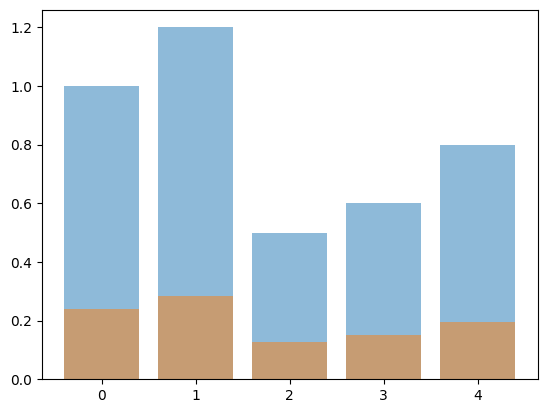

In [37]:
arr1 = [1,1.2,0.5,0.6,0.8]
plt.figure()
plt.bar(range(len(arr1)), arr1, alpha=0.5)
arr2 = changeTemp(arr1, temperature=1.1)
plt.bar(range(len(arr2)), arr2, alpha=0.5)
plt.show()

In [97]:
question = token.texts_to_sequences(["<sos> sherlock"])

In [99]:
def from_seq_to_text(seq):
    return token.sequences_to_texts([seq])

response = greedy_search_withT(question, max_len=15, T=1.4)
rta = from_seq_to_text(response)
rta

['holmes rushed away home fixed two very well of honest investments through assisting when just']

# Stochastic beam search + T

In [114]:
def beam_search(kBeams, maxOutputLen, candidates, T=1.0):

  if maxOutputLen < 1:
    return [[]]*kBeams, [1]*kBeams
  else:
    for curr in candidates:

      out = pad_sequences([curr], maxlen=maxLen)
      out = model.predict(out, verbose=0) #Probabilidades
      temp = changeTemp(out[0], temperature=T)
      newCandidates = np.argsort(temp)[::-1][:kBeams] #Agarramos los indices de los k-elementos con mas prob
      newCandProba = [temp[i] for i in newCandidates] #Agarramos su probabilidad
      newCandidates = [[num] for num in newCandidates] #Convertimos los numeros en listas de numeros por compatibilidad con pad_sequences

    if len(candidates) != 1:
        concatenated = np.concatenate((candidates, newCandidates), axis=1)
    else:
        concatenated = newCandidates

    return np.concatenate((newCandidates, beam_search(kBeams, maxOutputLen-1, concatenated)[0]), axis=1), np.multiply(newCandProba,  beam_search(kBeams, maxOutputLen-1, concatenated)[1])

In [119]:
question = token.texts_to_sequences(["<sos>"])

In [122]:
maxOutputLen = 7
kBeams = 10
candidates = question

outSeq, outProb = beam_search(kBeams, maxOutputLen, candidates, T=1.1)
result = token.sequences_to_texts(outSeq)

for i, sent in enumerate(result):
  print(f"prob: {outProb[i]:.2f} - Rta: {sent}")

prob: 0.00 - Rta: i have be to of the was
prob: 0.00 - Rta: it had have from from a is
prob: 0.00 - Rta: the were not back to his would
prob: 0.00 - Rta: ’ shall find for in my and
prob: 0.00 - Rta: he may see at for this in
prob: 0.00 - Rta: you are go in the some had
prob: 0.00 - Rta: but will do into upon an seemed
prob: 0.00 - Rta: and found think upon into one has
prob: 0.00 - Rta: there must take with and its on
prob: 0.00 - Rta: we should come out by it might
